In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import table
from astropy.table import Table
from astropy.io import ascii
import matplotlib.ticker as ticker

from scipy import stats
import pyspherematch as sm
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
from astroML.plotting import scatter_contour


SAGA_DIR = os.environ['SAGA_DIR']
SAGA_DROPBOX = os.environ['SAGA_DROPBOX']


In [2]:
from palettable.colorbrewer.qualitative import Dark2_8
if 'plt' in locals() and hasattr(plt, 'rcParams'):
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['font.size'] = 18.0
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Dark2_8.mpl_colors)
    plt.rcParams['legend.fontsize'] = 'medium'
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 7, 6
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 4

In [3]:
# READ DECALS AND SDSS ANAK CATALOGS IN
decals = Table.read(SAGA_DROPBOX+'/paper1_rvssb_data.fits.gz')
decals['r0'] = decals['r0']+0.1

base = Table.read(SAGA_DIR+'base_catalogs/base_sql_nsa61945.fits.gz')


m=(np.isnan(decals['dmagap_r_1.0asec'])) | (np.isinf(decals['dmagap_r_1.0asec']))
decals['dmagap_r_1.0asec'][m]=0
print decals.columns



<TableColumns names=('id','ra','dec','r0','r_err','Rh_exp','Rh_dev','Rh_psf','sb_sdsslike','insdss','star_decals','star_sdss','dmagap_g_1.0asec','dmagap_r_1.0asec','dmagap_g_5.0asec','dmagap_r_5.0asec')>


In [4]:
# MATCH BAD OBJECTS IN SDSS, REMOVE FROM DECALS
m=base['REMOVE'] != -1
m1,m2,dd = sm.spherematch(base['RA'][m], base['DEC'][m],\
           decals['ra'],decals['dec'],1.5/3600)
decals['r0'][m2] = 1000
print 'Number of bad matches ',np.size(m1)

# REMOVE STARS IN SDSS FROM DECALS-- DECALS has pretty bad s/g separation
m=base['PHOT_SG'] == 'STAR'
m1,m2,dd = sm.spherematch(base['RA'][m], base['DEC'][m],\
           decals['ra'],decals['dec'],2./3600)

decals['r0'][m2] = 1100

Number of bad matches  6851


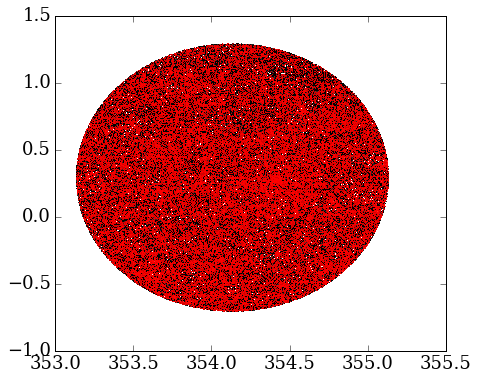

In [5]:
# COMPARE SPATIAL DISTRIBUTIONS
plt.plot(decals['ra'],decals['dec'],'k.',ms=1)
plt.plot(base['RA'],base['DEC'],'r.',ms=1)

decals['r0'] = decals['r0']

risa_ra=[354.282]
risa_dec= [0.211]
mm1,mm2,dd = sm.spherematch(decals['ra'],decals['dec'],risa_ra,risa_dec,2.5/3600)

decals['sb_sdsslike'][mm1]=24.5



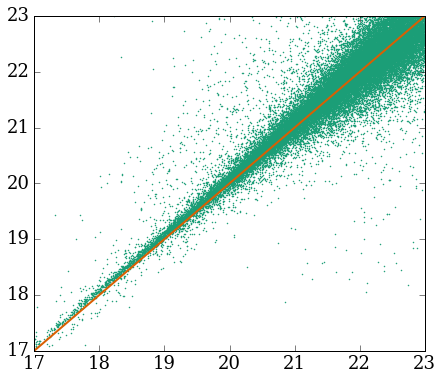

In [6]:
# CHECK IF THERE IS A PHOTOMETRIC OFFSET, CORRECT

m1,m2,dd = sm.spherematch(base['RA'], base['DEC'],\
           decals['ra'],decals['dec'],1.5/3600)
plt.plot(decals['r0'][m2],base['r'][m1],'.',ms=2)
plt.ylim(17,23)
plt.xlim(17,23)
plt.plot([17,23],[17,23])

In [7]:
# CREATE CLEAN SDSS BASE CATALOG 
b_rmv  = base['REMOVE'] == -1
b_fib  = base['FIBERMAG_R'] <= 23
b_gal  = base['PHOT_SG'] == 'GALAXY'
b_r21  = base['r'] - base['EXTINCTION_R'] <= 20.75
b_r21e  = base['r'] - base['EXTINCTION_R'] - 2.*base['r_err'] <= 20.75


rbase = base[b_rmv  & b_gal & b_fib & b_r21]
rerr_base = base[b_rmv  & b_gal & b_fib & b_r21e]

print 'Number of gal in SDSS base ',np.sum(b_rmv  & b_gal & b_fib & b_r21)


# MATCH TO ALL THINGS IN DECALS
m1,m2,dd = sm.spherematch(rbase['RA'], rbase['DEC'],\
           decals['ra'],decals['dec'],4./3600)
print 'Number of matches to DEACLs ',np.size(m1)
both = decals[m2]

# HOW MANY ARE ABOVE SAGA CRITERIA
mgood = both['r0'] - 3.*both['r_err'] < 20.75
print 'Number really passing SDSS limit',np.sum(mgood)

# LOOK AT THINGS THAT WEREN"T MATCHED
rbase['REMOVE'][m1]=0
m = rbase['REMOVE']!=0

sdss_not_decals = rbase[m]
print np.sum(m)

#for obj in rbase[m]:
#    print obj['r'],obj['RA'],obj['DEC']

Number of gal in SDSS base  8934
Number of matches to DEACLs  8897
Number really passing SDSS limit 8036
37


In [8]:
# THINGS IN DECALS THAT SHOULD BE IN SAGA
dgal = ~decals['star_decals']
d21   = decals['r0']+ 2.*decals['r_err'] < 20.75
dsize = (decals['Rh_dev'] < 12) & (decals['Rh_exp'] < 12) 

dres = (decals['dmagap_r_1.0asec'] > -8.0) 
saga_decals = decals[d21&dgal&dsize & dres]


mm1,mm2,dd = sm.spherematch(rerr_base['RA'], rerr_base['DEC'],\
           saga_decals['ra'],saga_decals['dec'],3./3600)
print np.size(saga_decals), np.size(mm1),np.size(saga_decals) - np.size(mm2)



# LOOK AT THINGS THAT WEREN"T MATCHED
saga_decals['r0'][mm2]=-99.0
m =  (saga_decals['r0']!=-99.0) & (saga_decals['r0'] <50)\
      & (~np.isinf(saga_decals['sb_sdsslike']))
print np.sum(m),np.size(mm2)

decals_not_sdss = saga_decals[m]
##for obj in decals_not_sdss:
#    print obj['dmagap_g_1.0asec'],obj['ra'],obj['dec']

#plt.plot(saga_decals['r0'],saga_decals['dmagap_r_1.0asec'],'.',ms=3)


8374 7743 631
656 7743


/Users/marlageha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


139


/Users/marlageha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in less


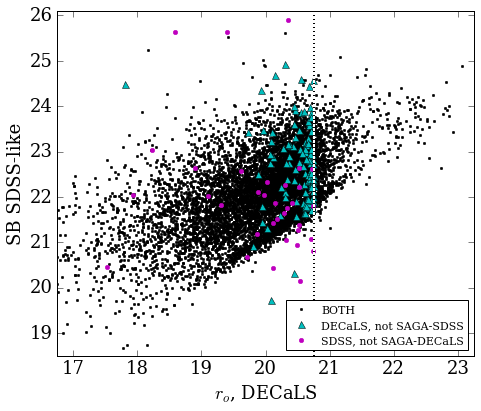

In [16]:
plt.rcParams['figure.figsize'] = 7, 6

risa_ra=[354.282]
risa_dec= [0.211]
r1,r2,dd = sm.spherematch(decals['ra'],decals['dec'],risa_ra,risa_dec,2.5/3600)
#plt.plot(decals['r0'][r1],decals['sb_sdsslike'][r1],'y*',ms=15,label='Risa galaxy')
#print decals['Rh_exp'][r1],decals['dmagap_r_1.0asec'][r1]
#plt.plot(saga_decals['r0'],saga_decals['sb_sdsslike'],'b.',ms=6,label='DECALS, no SDSS')

plt.plot(both['r0'],both['sb_sdsslike'],'k.',ms=5,label='BOTH')


#plt.plot(decals_not_sdss['r0'],decals_not_sdss['sb_sdsslike'],'b^',ms=7,label='DECALS, not SDSS')
d=ascii.read('/Users/marlageha/Desktop/mark.txt')
m=d['mark'] == 'false'
mm=decals['r0']<20.75
r1,r2,dd = sm.spherematch(decals['ra'][mm],decals['dec'][mm],d['ra'][m],d['dec'][m],1./3600)
tdecals=decals[mm]
plt.plot(tdecals['r0'][r1],tdecals['sb_sdsslike'][r1],'c^',ms=7,label='DECaLS, not SAGA-SDSS')
print np.size(r1)

plt.plot(sdss_not_decals['r']-sdss_not_decals['EXTINCTION_R'],sdss_not_decals['SB_EXP_R'],'m.',ms=9,label='SDSS, not SAGA-DECaLS')

plt.ylim(18.5,26.1)
plt.xlim(16.75,23.25)
plt.xlabel('$r_o$, DECaLS')
plt.ylabel('SB SDSS-like')


plt.axvline(20.75, c='w')
plt.axvline(20.75, c='k', ls=':')
plt.legend(loc=4,fontsize=11,frameon=True,numpoints = 1)


plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('fig_decals.png')


In [ ]:
# THINK ABOUT STARS
# CREATE CLEAN SDSS BASE CATALOG 
b_rmv  = base['REMOVE'] == -1
b_fib  = base['FIBERMAG_R'] <= 23
b_star = base['PHOT_SG'] == 'STAR'
b_r21  = base['r'] - base['EXTINCTION_R'] <= 20.75

sbase = base[b_rmv  & b_star & b_fib & b_r21]

s = decals['star_decals'] 
sr = decals['r0'] < 999
gal_decals = decals[~s & sr]


# MATCH SDSS STARS TO DECAL GALAXIES
m1,m2,dd = sm.spherematch(sbase['RA'], sbase['DEC'],\
           gal_decals['ra'],gal_decals['dec'],2./3600)
print np.size(m1)
for obj in gal_decals[m2]:
    r = obj['Rh_exp']
    if (r == 0):
        r=obj['Rh_dev']
    print obj['r0'],obj['ra'],obj['dec']